# Face Unlock with 2D Data
*A deep learning approach*

Today we are going to use deep learning to create a face unlock algorithm. To complete our puzzle, we need three main pieces. 

- a find faces algorithm
- a way to embed the faces in vector space
- a function to compare the encoded faces

In [1]:
!pip install facenet-pytorch

## Find Faces

First of all, we need a way to find a face inside an image.  We can use an end-end approach called [MTCNN](https://arxiv.org/abs/1604.02878) (Multi-task Cascaded Convolutional Networks). 

Just a little bit of technical background, it is called *Cascaded* because it is composed of multiple stages, each stage has its neural network. The following image shows the framework. 

**[INSERT_IMG]**

We rely on the MTCNN implementation from facenet-pytorch [repo](https://github.com/timesler/facenet-pytorch). 


### Data

We need images! I have put together a couple of images of myself, Leonardo di Caprio and Matt Demon.

Following PyTorch best practices, I load up the dataset using `ImageFolder`. I created the `MTCNN` instance and pass it to the dataset using the `transform` parameter.  

My folder structure is the following:

```
./faces
├── di_caprio
│   ├── ....jpg
├── matt_demon
│   ├── ....jpg
└── me
│   ├── ....jpg

```



The `MTCNN` will automatically crop and resize the input, I used an `image_size=160` because the model will are going to use was trained with images with that size. I also add `18` pixels of margin, just to be sure we include the whole face.


In [2]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from facenet_pytorch import MTCNN, InceptionResnetV1
from pathlib import Path
from typing import Union, Callable

data_root = Path('.')
# create the MTCNN network
transform = MTCNN(image_size=160, margin=18)

ds = ImageFolder(root=data_root / 'faces', transform=transform)
# our dataset is so small that the batch_size can equal to its lenght
dl = DataLoader(ds, batch_size=len(ds))

ds[1]

(tensor([[[ 0.9023,  0.9180,  0.9180,  ...,  0.8398,  0.8242,  0.8242],
          [ 0.9023,  0.9414,  0.9492,  ...,  0.8555,  0.8320,  0.8164],
          [ 0.9336,  0.9805,  0.9727,  ...,  0.8555,  0.8320,  0.7930],
          ...,
          [-0.7070, -0.7383, -0.7305,  ...,  0.4102,  0.3320,  0.3711],
          [-0.7539, -0.7383, -0.7305,  ...,  0.3789,  0.3633,  0.4102],
          [-0.7383, -0.7070, -0.7227,  ...,  0.3242,  0.3945,  0.4023]],
 
         [[ 0.9492,  0.9492,  0.9492,  ...,  0.9336,  0.9258,  0.9258],
          [ 0.9336,  0.9492,  0.9492,  ...,  0.9492,  0.9336,  0.9258],
          [ 0.9414,  0.9648,  0.9414,  ...,  0.9570,  0.9414,  0.9258],
          ...,
          [-0.3633, -0.3867, -0.3867,  ...,  0.6133,  0.5352,  0.5820],
          [-0.3945, -0.3867, -0.3945,  ...,  0.5820,  0.5742,  0.6211],
          [-0.3711, -0.3633, -0.4023,  ...,  0.5273,  0.6055,  0.6211]],
 
         [[ 0.8867,  0.8867,  0.8945,  ...,  0.8555,  0.8477,  0.8477],
          [ 0.8789,  0.8867,

Perfect, the dataset returns a tensor. Let's visualize all the inputs. They have been normalized by the MTCNN image-wise. The last three images of the last row are selfies of myself :)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


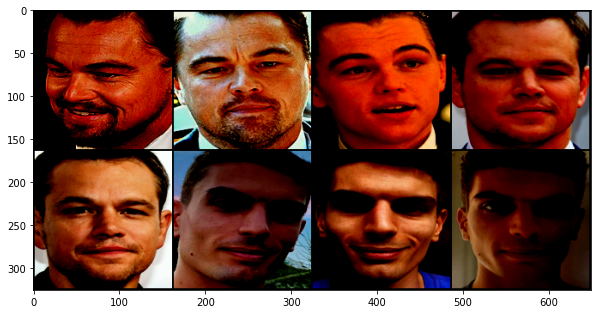

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
for (imgs, labels) in dl:
    plt.imshow(make_grid(imgs, nrow=4).permute(1,2,0).numpy())
    break


## Embed

Our data pipeline is ready. To compare faces and find out if two are similar, we need a way to encode them in a vector space where, if two faces are similar, the two vectors associated with them are also similar.

We can use one model trained on one of the famous face dataset, such as [`vggface2`](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) and use the output of the last layer (latent space) before the classification head as encoding. 

A model trained on a faces dataset must have learn important features about the inputs. The last layer (just before the fully connected layers) encodes the high level features of these images. Thus, we can use it to embed our inputs in a vector space where, hopefully, similar images are close to each other.

In details, we are going to use a inception resnet trained on the `vggface2` dataset. The embeddings space has `512` dimentions. 

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

with torch.no_grad():
    for (imgs, labels) in dl:
        embs = resnet(imgs)
        break

embs.shape

torch.Size([8, 512])

Perfect, we had `8` images and we obtained `8` vectors

## Similarity

To compare our vectors, we can use `cosine_similarity` to see how much they are *close to each other*. Cosine similarity will outputs a value between [-1, 1]. In the naive case, where the two compared vectors are the same, their similarity is 1. So the closest to 1, the similar. 

We can now find all the distances between each pair in our dataset.

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:model[0][2]
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        x = tensor.clone()
        for t, m, s in zip(x, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return x

# My un-normalization function is not quite right since the images are normalized with their own values and not with the std and mean of the whole dataset.
un_normalize = UnNormalize([ 0.485, 0.456, 0.406 ], (0.247, 0.243, 0.261))

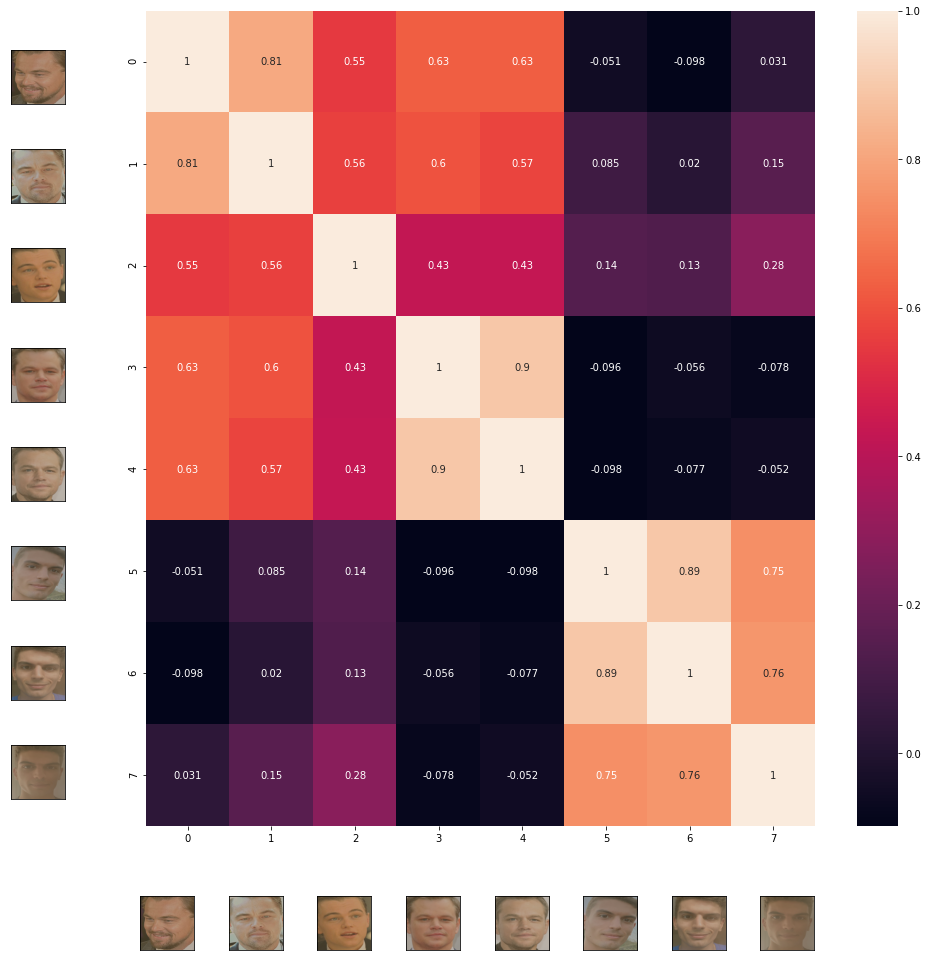

In [7]:
import seaborn as sns
import numpy as np

similarity_matrix = torch.zeros(embs.shape[0], embs.shape[0])

for i in range(embs.shape[0]):
    for j in range(embs.shape[0]):
        similarity_matrix[i,j] = torch.cosine_similarity(embs[i].view(1, -1), embs[j].view(1, -1))


fig = plt.figure(figsize=(15, 15))

sns.heatmap(similarity_matrix.numpy(), annot = True,)

numicons = 8
for i in range(numicons):
    axicon = fig.add_axes([0.12+0.082*i,0.01,0.05,0.05])
    axicon.imshow(un_normalize(ds[i][0]).permute(1,2,0).numpy())
    axicon.set_xticks([])
    axicon.set_yticks([])

    axicon = fig.add_axes([0, 0.15 + 0.092 * i,.05,0.05])
    axicon.imshow(un_normalize(ds[len(ds) - 1 - i][0]).permute(1,2,0).numpy())
    axicon.set_xticks([])
    axicon.set_yticks([])

Apparently, I am not very similar to Matt or Leo, but they have something in common!

We can go futher and run PCA on the embeddings and project the images in a 2-D plane

[]

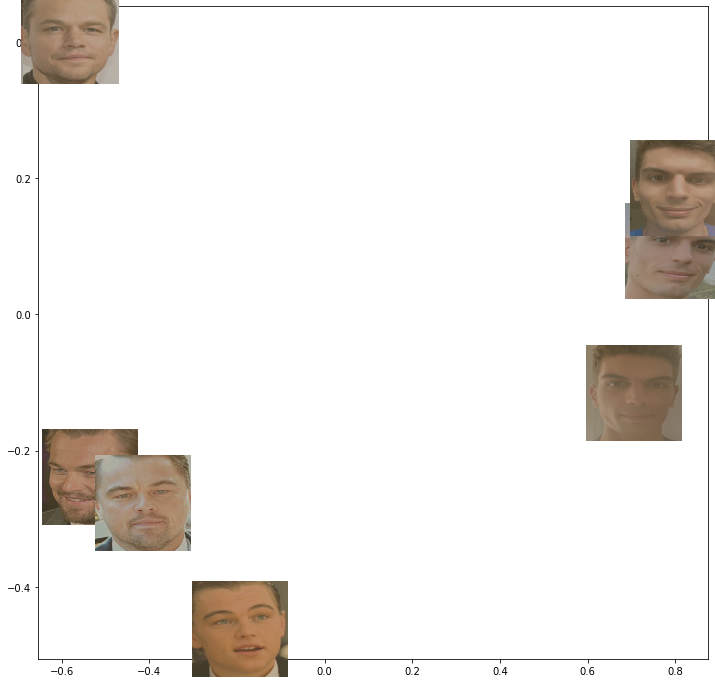

In [8]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def pca(x: torch.Tensor, k: int = 2) -> torch.Tensor:
    """
    From http://agnesmustar.com/2017/11/01/principal-component-analysis-pca-implemented-pytorch/
    """
    # preprocess the data
    X_mean = torch.mean(x, 0)
    x = x - X_mean.expand_as(x)
    # svd
    U, S, V = torch.svd(torch.t(x))
    return torch.mm(x, U[:, :k])

points = pca(embs, k=2)
plt.rcParams["figure.figsize"] = (12,12)

fig, ax = plt.figure(), plt.subplot(111)
plt.scatter(points[:,0], points[:,1])
for i, p in enumerate(points):
    x, y = p[0], p[1]
    img = un_normalize(ds[i][0])
    img_np = img.permute(1, 2, 0).numpy().squeeze()
    ab = AnnotationBbox(OffsetImage(img_np, zoom=0.6), (x, y), frameon=False)
    ax.add_artist(ab)

plt.plot()

Take this image with a grain of salt. We are compresisng 512 dimensions in 2, so we are loosing lots of data.

## Face Unlock

Okay, we have a way to find faces and to see if they are similar to each other, now we can create our face unlock algorithm.


My idea is to take `n` images of the allowed person, find the center in the embedding space, select a treshold and see if the cosine similarity between the center and a new image is less or bigger than it. 

In [9]:
from dataclasses import dataclass, field
from typing import List, Callable
from PIL import Image

@dataclass
class FaceUnlock:
    
    images: List[Image.Image] = field(default_factory = list)
    th: float = 0.8
    transform: Callable =  MTCNN(image_size=160, margin=18)
    embedder: torch.nn.Module = InceptionResnetV1(pretrained='vggface2').eval()
    center: torch.Tensor = None

    def __post_init__(self):
        faces = torch.stack(list(map(self.transform, self.images)))
        embds = self.embedder(faces)

        self.center = embds.sum(0) / embds.shape[0]
    
    def __call__(self, x: Image.Image) -> bool:
        face = self.transform(x)
        emb = self.embedder(face.unsqueeze(0))

        similarity = torch.cosine_similarity(emb.view(1, -1), self.center.view(1, -1))
        is_me =  similarity > self.th

        return is_me, similarity

# load pictures of myself
me = data_root / 'faces' / 'me'
images = list(map(Image.open, me.glob('*')))
# initialize face unlock with my images
face_unlock = FaceUnlock(images)

Let's test it!

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual

def unlock_with_filepath(path):
    img = Image.open(path)
    
    is_me, similarity =  face_unlock(img)
    print(f"{'🔓' if is_me else '🔒'} similarity={similarity.item():.3f}")

    fig = plt.figure()
    plt.imshow(img)


test_root = data_root / 'faces_test'

interact(unlock_with_filepath, path=list(test_root.glob('*')))

interactive(children=(Dropdown(description='path', options=(PosixPath('faces_test/202008-full.jpg'), PosixPath…

<function __main__.unlock_with_filepath(path)>